### Looking at the enrichment of cancer genes in novel and all utrons in the bladder cancer samples
- 1) for all utrons
- 2) for novel utrons
- 3) for all transcripts (control)

In [2]:
import pandas as pd
import numpy as np
import sqlite3 
import math


# Open utrons db
cnx = sqlite3.connect('/shared/sudlab1/General/projects/utrons_project/BladderCancerUtrons/431BladderUtrons.db')
cnx.execute("ATTACH '/shared/sudlab1/General/annotations/hg38_noalt_ensembl85/csvdb' as annotations")


# Open cancer file
cancerFile = '/shared/sudlab1/General/projects/utrons_project/ReferenceFiles/cancerGenes.txt'
cancerGenes = pd.read_csv(cancerFile, sep="\t", header=None)
sup = ["suppressor"]
onc = ["oncogene"]
unk = ["Unknown"]

# Get lists of genes
cancerSupGenes = cancerGenes[cancerGenes[1].isin(sup)].ix[:,0].tolist()
cancerOncGenes = cancerGenes[cancerGenes[1].isin(onc)].ix[:,0].tolist()
cancerUnkGenes = cancerGenes[cancerGenes[1].isin(unk)].ix[:,0].tolist()


# Open list of systematic utrons
sysFile = '/shared/sudlab1/General/projects/utrons_project/misc_files/systematicUtronGenes.txt'
for line in open(sysFile).readlines():
    sysUtronGenes = line.split()
    
    
# Number of samples to use
sampleCount = 432

In [23]:
"""
SQL QUERIES TO GET TRANSCRIPT IDS TO BE USED LATER
"""

#########################################################
# Dataframe of all transcript IDs 
query_text1 = '''
    SELECT tc.match_transcript_id AS match_id, tc.transcript_id AS Name
    FROM transcript_class AS tc
    WHERE tc.track="agg-agg-agg"
    ORDER BY match_transcript_id
    '''
transcriptIds = pd.read_sql_query(query_text1, cnx)



#########################################################
# Dataframe of novel UTRons IDs and matched transcript IDs
query_text1 = '''
    SELECT uid.transcript_id AS Name, ti.gene_name AS Gene
    FROM novel_utrons_ids AS uid
    INNER JOIN transcript_class AS tc
    ON tc.transcript_id = uid.transcript_id
    INNER JOIN annotations.transcript_info AS ti
    ON ti.transcript_id = tc.match_transcript_id
    WHERE uid.track='agg-agg-agg'
    GROUP BY uid.transcript_id
    '''
novelUtronsDf = pd.read_sql_query(query_text1, cnx)
novelUtronsDf = novelUtronsDf[~novelUtronsDf["Gene"].isin(sysUtronGenes)]

#########################################################
# Dataframe of all UTRon IDs and matched transcript IDs
query_text1 = '''
    SELECT uid.transcript_id AS Name, ti.gene_name AS Gene
    FROM all_utrons_ids AS uid
    INNER JOIN transcript_class AS tc
    ON tc.transcript_id = uid.transcript_id
    INNER JOIN annotations.transcript_info AS ti
    ON ti.transcript_id = tc.match_transcript_id
    WHERE uid.track='agg-agg-agg'
    GROUP BY uid.transcript_id
    '''
allUtronsDf = pd.read_sql_query(query_text1, cnx)
allUtronsDf = allUtronsDf[~allUtronsDf["Gene"].isin(sysUtronGenes)]

#########################################################
# Dataframe of all transcript IDs and gene names
query_text1 = '''
    SELECT tc.transcript_id AS Name, ti.gene_name as Gene
    FROM transcript_class AS tc
    INNER JOIN annotations.transcript_info AS ti
    ON ti.transcript_id = tc.match_transcript_id
    WHERE tc.track='agg-agg-agg'
    GROUP BY tc.transcript_id
    '''
controlTranscriptsDf = pd.read_sql_query(query_text1, cnx)

In [4]:
"""
Function getTpms
1 - Takes a dataframe of transcript ids
2 - Returns a dataframe of sample tpms

"""


# Get tpms for UTRons
def getTpms(sample, runNum, index, Dataframe):
    
    # Load file into dataframe
    sampleFile = '/shared/sudlab1/General/projects/utrons_project/BladderCancerUtrons/Quantifications/%s_agg-agg-agg.sf' % sample
    sampleDf = pd.read_csv(sampleFile, sep='\t') 
    
    # Copy only Tx ids and TPM values from dataframe
    sampleDf = sampleDf[[0,3]].copy() 
    
    # Merge with Utrons DF (get only utron tpms)
    sampleDf = pd.merge(Dataframe, sampleDf, right_on="Name", left_on="Name")
    
    # Make columns named with the sample number
    indexname = "TPM_%d" % index
    sampleDf[indexname] = sampleDf["TPM"]

    # If passed with runNum == 1, return tpms AND tx IDs, else return just the tpms
    if runNum ==1:
        return sampleDf[["Name","Gene", indexname]]
    if runNum ==2:
        return sampleDf[[indexname]]
    


In [5]:
"""
GET TPMS FOR NOVEL UTRONS
"""

# Loop through samples and get tpms
novelUtronTpms = getTpms("ZF-WT-1", 1, 1, novelUtronsDf)
for num in range(2,sampleCount,1):
    if num != 252 and num != 347:
        sample = "ZF-WT-%d" % num
        sampleTpms = getTpms(sample, 2, num, novelUtronsDf)
        novelUtronTpms = pd.concat([novelUtronTpms, sampleTpms], axis=1)


In [6]:
"""
GET TPMS FOR ALL UTRONS
"""

# Loop through samples and get tpms
allUtronTpms = getTpms("ZF-WT-1", 1, 1, allUtronsDf)
for num in range(2,sampleCount,1):
    if num != 252 and num != 347:
        sample = "ZF-WT-%d" % num
        sampleTpms = getTpms(sample, 2, num, allUtronsDf)
        allUtronTpms = pd.concat([allUtronTpms, sampleTpms], axis=1)
        print num,

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 27

In [24]:
"""
GET TPMS FOR CONTROL TRANSCRIPTS
"""

# Loop through samples and get control TranscriptsDf
controlTpms = getTpms("ZF-WT-1", 1, 1, controlTranscriptsDf)
for num in range(2,sampleCount,1):
    if num != 252 and num != 347:
        sample = "ZF-WT-%d" % num
        sampleTpms = getTpms(sample, 2, num, controlTranscriptsDf)
        controlTpms = pd.concat([controlTpms, sampleTpms], axis=1)
        print num,

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 27

#### Now have lists of all utron tpms, novel tpms and all tx tpms
#### Next = counting the percentages of cancer genes

In [7]:
"""
Annotate the Dataframes with splice information and cancer status 
"""


# File with Length info of the novel UTRons
lengthFile = "/shared/sudlab1/General/projects/utrons_project/misc_files/SpliceSite/novelLengths.txt"
lengthInfo = pd.read_csv(lengthFile, sep="\t")

# File of novel utrons with non-canonical splice sites
badsplicefile = "/shared/sudlab1/General/projects/utrons_project/misc_files/SpliceSite/novelUtrons_unknown_100000bp.txt"
badspliceUtrons = pd.read_csv(badsplicefile, header=None, sep="\t", index_col=0)[1].tolist()


"""
Function Returns the cancer status of each gene passed to it
"""

def cancerStatus(row):
    gene = row["Gene"]
    if gene in cancerOncGenes:
        return "oncogene"
    elif gene in cancerSupGenes:
        return "suppressor"
    elif gene in cancerUnkGenes:
        return "unknown"
    else:
        return "None"

    
    
"""
Function returns the splice site status (1) = known, (0) = unknown
"""    
def spliceStatus(row):
    tx = row["Name"]
    if tx in badspliceUtrons:
        return 0
    else:
        return 1

In [27]:
# Run functions above
novelTpms = novelUtronTpms
novelTpms["Cancer"] = novelTpms.apply(cancerStatus, axis=1)
novelTpms["Splice"] = novelTpms.apply(spliceStatus, axis=1)

knownTpms = allUtronTpms
knownTpms["Cancer"] = knownTpms.apply(cancerStatus, axis=1)
knownTpms["Splice"] = knownTpms.apply(spliceStatus, axis=1)

controlTxTpms = controlTpms
controlTxTpms["Cancer"] = controlTxTpms.apply(cancerStatus, axis=1)
controlTxTpms["Splice"] = controlTxTpms.apply(spliceStatus, axis=1)

In [9]:
"""
Function getCancerPercentages
1- Takes a dataframe of TPMs as input and a sample number
2- Returns a list of percentages of cancer enrichment for the sample
"""

tpmRange = range(0,410,10)

# Get cancer percentages
def getCancerPercentages(Dataframe, sample):
    
    # Get Dataframe of sample tpms
    sampleIndex = "TPM_%d" % sample
    sampleDataframe = Dataframe[[sampleIndex, "Cancer"]]
    
    # Lists to hold percentages
    oncogeneList = []
    suppressorList = []
    unknownList = []
    
    # Loop through TPM range
    for tpm in tpmRange:
        sampleTpmValues = sampleDataframe[sampleDataframe[sampleIndex] >= tpm]
        geneCount = len(sampleTpmValues)
        
        if geneCount > 0:
            numOncogenes = len(sampleTpmValues[sampleTpmValues["Cancer"]=="oncogene"])
            numSupressors = len(sampleTpmValues[sampleTpmValues["Cancer"]=="suppressor"])
            numUnknown = len(sampleTpmValues[sampleTpmValues["Cancer"]=="unknown"])

            percentageOncogenes = (float(numOncogenes) / geneCount) * 100
            percentageSupressors = (float(numSupressors) / geneCount) * 100
            percentageUnknown = (float(numUnknown) / geneCount) * 100
        
        else:
            percentageOncogenes = None
            percentageSupressors = None
            percentageUnknown = None
            
        oncogeneList.append(percentageOncogenes)
        suppressorList.append(percentageSupressors)
        unknownList.append(percentageUnknown)
        
    return oncogeneList, suppressorList, unknownList



"""
Function averageArray
1 - takes output from getCancerPercentages
2 - Returns a list of percentages averaged across all samples
"""

def averageArray(geneArray):
    numTpms = len(geneArray)
    
    Averages = []
    for num in range(0, numTpms, 1):
        tpms = geneArray[num,:]
        tpmTotal = sum([a for a in tpms if a != None])
        tpmLength = len([a for a in tpms if a != None])
        tpmAverage = tpmTotal / tpmLength
        Averages.append(tpmAverage)
        
    return Averages

In [10]:
######################################################
# Getting Novel Percentages using getCancerPercentages

novelOncogeneArray, novelSuppressorArray, novelUnknownArray = getCancerPercentages(novelTpms, 1)

for num in range(2, sampleCount, 1):
    if num != 252 and num != 347:
        a , b ,c = getCancerPercentages(novelTpms, num)
        novelOncogeneArray = np.column_stack([novelOncogeneArray, a])
        novelSuppressorArray = np.column_stack([novelSuppressorArray, b])
        novelUnknownArray = np.column_stack([novelUnknownArray, c])
        
novelOncPercentages = averageArray(novelOncogeneArray)
novelSupPercentages = averageArray(novelSuppressorArray)
novelUnkPercentages = averageArray(novelUnknownArray)

In [11]:
######################################################
# Getting Known Percentages using getCancerPercentages

knownOncogeneArray, knownSuppressorArray, knownUnknownArray = getCancerPercentages(knownTpms, 1)

for num in range(2, sampleCount, 1):
    if num != 252 and num != 347:
        a , b ,c = getCancerPercentages(knownTpms, num)
        knownOncogeneArray = np.column_stack([knownOncogeneArray, a])
        knownSuppressorArray = np.column_stack([knownSuppressorArray, b])
        knownUnknownArray = np.column_stack([knownUnknownArray, c])
        
knownOncPercentages = averageArray(knownOncogeneArray)
knownSupPercentages = averageArray(knownSuppressorArray)
knownUnkPercentages = averageArray(knownUnknownArray)

In [28]:
######################################################
# Getting Control TX percentages using getCancerPercentages

controlOncogeneArray, controlSuppressorArray, controlUnknownArray = getCancerPercentages(controlTxTpms, 1)

for num in range(2, sampleCount, 1):
    if num != 252 and num != 347:
        a , b ,c = getCancerPercentages(controlTxTpms, num)
        controlOncogeneArray = np.column_stack([controlOncogeneArray, a])
        controlSuppressorArray = np.column_stack([controlSuppressorArray, b])
        controlUnknownArray = np.column_stack([controlUnknownArray, c])
        
controlOncPercentages = averageArray(controlOncogeneArray)
controlSupPercentages = averageArray(controlSuppressorArray)
controlUnkPercentages = averageArray(controlUnknownArray)

Populating the interactive namespace from numpy and matplotlib


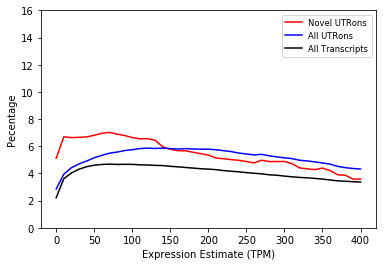

In [41]:
"""
Novel Vs known Utrons plot
"""

%pylab inline

# Plot vals
pylab.plot(tpmRange, novelOncPercentages, color="red", label="Novel UTRons")
pylab.plot(tpmRange, knownOncPercentages, color="blue", label="All UTRons")
pylab.plot(tpmRange, controlOncPercentages, color="black", label="All Transcripts")

# Figure options
pylab.ylim(0,16)
pylab.ylim(0,16)

pylab.ylabel("Pecentage")
pylab.xlabel("Expression Estimate (TPM)")

pylab.legend(fontsize="small")
pylab.savefig("./images/InitialOncogenePercentages", dpi=300)

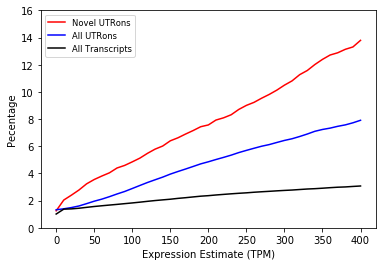

In [42]:
pylab.plot(tpmRange, novelSupPercentages, color="red", label="Novel UTRons")
pylab.plot(tpmRange, knownSupPercentages, color="blue", label="All UTRons")
pylab.plot(tpmRange, controlSupPercentages, color="black", label="All Transcripts")


# Figure options
pylab.ylim(0,16)
pylab.ylim(0,16)

pylab.ylabel("Pecentage")
pylab.xlabel("Expression Estimate (TPM)")

pylab.legend(fontsize="small")
pylab.savefig("./images/InitialSuppressorPercentages", dpi=300)

In [13]:
#######################################################
# Comparing novel utrons with good / bad splice sites


unknownSpliceUtrons = novelTpms[novelTpms["Splice"] == 0]
knownSpliceUtrons = novelTpms[novelTpms["Splice"] == 1]

unknownOncsArray, unknownSupsArray, unknownUnksArray = getCancerPercentages(unknownSpliceUtrons, 1)
knownOncsArray, knownSupsArray, knownUnksArray = getCancerPercentages(knownSpliceUtrons, 1)


for num in range(2, sampleCount, 1):
    if num != 252 and num != 347:
        a , b ,c = getCancerPercentages(unknownSpliceUtrons, num)
        unknownOncsArray = np.column_stack([unknownOncsArray, a])
        unknownSupsArray = np.column_stack([unknownSupsArray, b])
        unknownUnksArray = np.column_stack([unknownUnksArray, c])
        
        a , b ,c = getCancerPercentages(knownSpliceUtrons, num)
        knownOncsArray = np.column_stack([knownOncsArray, a])
        knownSupsArray = np.column_stack([knownSupsArray, b])
        knownUnksArray = np.column_stack([knownUnksArray, c])
        
unknownOncsPercs = averageArray(unknownOncsArray)
unknownSupsPercs = averageArray(unknownSupsArray)
unknownUnksPercs = averageArray(unknownUnksArray)

knownOncsPercs = averageArray(knownOncsArray)
knownSupsPercs = averageArray(knownSupsArray)
knownUnksPercs = averageArray(knownUnksArray)

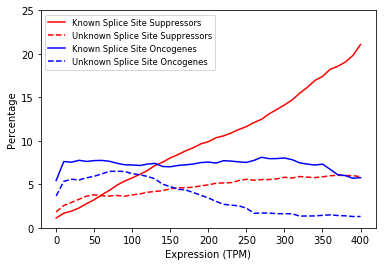

In [88]:
"""
Known splice site vs unknown splice site plot
"""

pylab.plot(tpmRange, knownSupsPercs, color="red", label="Known Splice Site Suppressors")
pylab.plot(tpmRange, unknownSupsPercs,"--", color="red" , label="Unknown Splice Site Suppressors")
pylab.plot(tpmRange, knownOncsPercs, color="blue" , label="Known Splice Site Oncogenes")
pylab.plot(tpmRange, unknownOncsPercs,"--", color="blue" , label="Unknown Splice Site Oncogenes")
pylab.ylim(0,25)
pylab.xlabel("Expression (TPM)")
pylab.ylabel("Percentage")
pylab.legend(fontsize="small")
pylab.savefig("./images/9_knownvsUnknown", dpi=300)

In [15]:
"""
Function returns the percentages of cancer genes above and below the supplied Length Value
Input = length
Output = cancer percentages (6 lists)
"""

def getLengthPercentages(Length):

    LengthThreshold = Length
    smallUtrons = lengthInfo[lengthInfo["Length"]<=LengthThreshold]

    shortUtrons = novelTpms[novelTpms["Name"].isin(smallUtrons["transcript_id"])]
    longUtrons = novelTpms[~novelTpms["Name"].isin(smallUtrons["transcript_id"])]



    shortOncsArray, shortSupsArray, shortUnksArray = getCancerPercentages(shortUtrons, 1)
    longOncsArray, longSupsArray, longUnksArray = getCancerPercentages(longUtrons, 1)


    for num in range(2, sampleCount, 1):
        if num != 252 and num != 347:
            a , b ,c = getCancerPercentages(shortUtrons, num)
            shortOncsArray = np.column_stack([shortOncsArray, a])
            shortSupsArray = np.column_stack([shortSupsArray, b])
            shortUnksArray = np.column_stack([shortUnksArray, c])

            a , b ,c = getCancerPercentages(knownSpliceUtrons, num)
            longOncsArray = np.column_stack([longOncsArray, a])
            longSupsArray = np.column_stack([longSupsArray, b])
            longUnksArray = np.column_stack([longUnksArray, c])

    shortOncsPercs = averageArray(shortOncsArray)
    shortSupsPercs = averageArray(shortSupsArray)
    shortUnksPercs = averageArray(shortUnksArray)

    longOncsPercs = averageArray(longOncsArray)
    longSupsPercs = averageArray(longSupsArray)
    longUnksPercs = averageArray(longUnksArray)
    
    
    return shortOncsPercs, shortSupsPercs, shortUnksPercs, longOncsPercs, longSupsPercs, longUnksPercs

In [16]:
shortOncsPercs, shortSupsPercs, shortUnksPercs, longOncsPercs, longSupsPercs, longUnksPercs = getLengthPercentages(150)

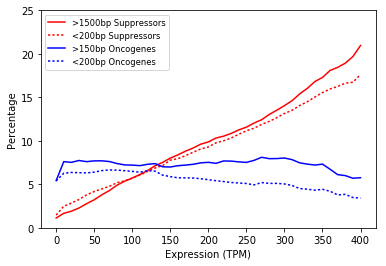

In [95]:
pylab.plot(tpmRange, longSupsPercs, color="red", label=">1500bp Suppressors")
pylab.plot(tpmRange, shortSupsPercs,":k", color="red", label="<200bp Suppressors")
pylab.plot(tpmRange, longOncsPercs, color="blue", label=">150bp Oncogenes")
pylab.plot(tpmRange, shortOncsPercs,":k", color="blue", label="<200bp Oncogenes")
pylab.ylim(0,25)
pylab.xlabel("Expression (TPM)")
pylab.ylabel("Percentage")
pylab.legend(fontsize="small")
pylab.savefig("./images/9_longvsshort", dpi=300)

In [165]:
"""
Finding IDs of cancerous UTRons
"""


"""
Function getIds
1 - inputs samplenumber , dataframe and tpm threshold
2 - outputs list of oncogenes, suppressor genes and unknown genes above the threshold for the sample
"""

def getIds(sampleNumber, Dataframe, tpm):
    sampleIndex = "TPM_%d" % sampleNumber
    sampleDataframe = Dataframe[["Name", "Gene",sampleIndex, "Cancer", "Splice"]]
    
    # Lists to hold percentages
    oncogeneList = []
    suppressorList = []
    unknownList = []
    
    sampleTpmValues = sampleDataframe[sampleDataframe[sampleIndex] >= tpm]
    sampleTpmValues = sampleTpmValues[sampleTpmValues["Splice"]==1]
    
    oncogeneTpms = sampleTpmValues[sampleTpmValues["Cancer"]=="oncogene"]
    suppressorTpms = sampleTpmValues[sampleTpmValues["Cancer"]=="suppressor"]
    unknownTpms = sampleTpmValues[sampleTpmValues["Cancer"]=="unknown"]
    
    return oncogeneTpms[["Name", "Gene"]], suppressorTpms[["Name", "Gene"]], unknownTpms[["Name", "Gene"]]
        
        
oncogeneDf, suppressorDf, unknownDf = getIds(1, knownTpms, 400)
for num in range(2, sampleCount, 1):
    if num != 252 and num != 347:
        a , b ,c = getIds(num, knownTpms, 400)
        oncogeneDf = pd.concat([oncogeneDf, a], axis=0) 
        suppressorDf = pd.concat([suppressorDf, b], axis=0) 
        unknownDf = pd.concat([unknownDf, c], axis=0) 
        
oncogeneDf = oncogeneDf.drop_duplicates("Name")
suppressorDf = suppressorDf.drop_duplicates("Name")
unknownDf = unknownDf.drop_duplicates("Name")

In [166]:
tpm = 400

oncogeneDf.to_csv("/shared/sudlab1/General/projects/utrons_project/misc_files/cancerUtrons/oncogenes_%dTPM.txt" % tpm, sep="\t", header=None, index=None)
suppressorDf.to_csv("/shared/sudlab1/General/projects/utrons_project/misc_files/cancerUtrons/suppresor_%dTPM.txt" % tpm, sep="\t", header=None, index=None)
unknownDf.to_csv("/shared/sudlab1/General/projects/utrons_project/misc_files/cancerUtrons/unknown_%dTPM.txt" % tpm, sep="\t", header=None, index=None)

In [167]:
print oncogeneDf

                  Name       Gene
1641   ENST00000356674  HNRNPA2B1
14134  ENST00000547914       NACA
2384   ENST00000377795       CD74
16027  ENST00000566564       MMP2
32568   MSTRG.77569.12      COX6C
25530   MSTRG.33994.10      H3F3B
3082   ENST00000398137      U2AF1
4692   ENST00000429589     EIF4A2
11452  ENST00000522377      NDRG1
8546   ENST00000485118       MUC1
6947   ENST00000462317       MUC1
32574    MSTRG.77569.9      COX6C
17701  ENST00000586967       CALR
10951  ENST00000517682      COX6C
14576  ENST00000553237       CDK4
6346   ENST00000452625      MYH11
10945  ENST00000517599      NDRG1
11438  ENST00000522246       CD74
11683  ENST00000524245      COX6C
19215  ENST00000610468       MUC1
32570   MSTRG.77569.15      COX6C
466    ENST00000269571      ERBB2
11521  ENST00000522934      COX6C
9379   ENST00000496706      YWHAE
17812  ENST00000588032       TPM4
17307  ENST00000582648      ERBB2
9478   ENST00000498431       MUC1
21028   MSTRG.11829.27       HRAS
19158  ENST000

In [168]:
print suppressorDf

                  Name    Gene
1498   ENST00000349264     B2M
3540   ENST00000412585   HLA-B
15104  ENST00000557901     B2M
23394   MSTRG.26040.11     B2M
15464  ENST00000561139     B2M
15493  ENST00000561424     B2M
13824  ENST00000544417     B2M
23397    MSTRG.26040.4     B2M
23396    MSTRG.26040.3     B2M
10192  ENST00000508608    CAST
10392  ENST00000510500    CAST
32796    MSTRG.79128.1  CDKN2A


In [169]:
print unknownDf

                  Name    Gene
11609  ENST00000523636  PABPC1
10985  ENST00000517990  PABPC1
11292  ENST00000520868  PABPC1
32539   MSTRG.77274.22  PABPC1
21095    MSTRG.11990.3    LDHA
11089  ENST00000519004  PABPC1
4493   ENST00000426447   PDAP1
11152  ENST00000519622  PABPC1
32538   MSTRG.77274.19  PABPC1
13893  ENST00000545215    LDHA
16381  ENST00000569857     PKM
2462   ENST00000379412    LDHA
11454  ENST00000522387  PABPC1
20715     MSTRG.108.41    GNB1
13535  ENST00000541097    LDHA
8656   ENST00000486690    LDHA
12744  ENST00000532746    RPS2
13136  ENST00000536528    LDHA
5859   ENST00000445558   PSMD2
5100   ENST00000435120    MLF2
